# Машинное обучение
## ВМК МГУ, весна 2015/2016
## Лабораторная работа 1. Линейные модели

ФИО: Гой Антон Сергеевич

Группа: 517

Данное задание посвящено применению линейных моделей в задачах классификации и регрессии. Вы научитесь:
* делать one-hot-кодирование категориальных признаков
* обучать логистическую и линейную регрессию
* отбирать признаки с помощью LASSO
* вычислять метрики качества классификации и регрессии
* выбирать лучший классификатор при ограничениях на точность или полноту
* калибровать вероятности
* реализовывать градиентный спуск (если захотите)


In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sps

%matplotlib inline

## Часть 1. Научные гранты в Австралии

![](http://imgur.com/cBdDBO3.jpg)

В данной части мы будем работать с задачей "Predict Grant Applications" (https://www.kaggle.com/c/unimelb/data), где для заявки на грант требуется предсказать, одобрят её или нет. Будем использовать лишь 40 признаков из имеющихся 249. Файлы для работы можно найти по ссылкам:
* https://db.tt/iYzRzQYP (обучение)
* https://db.tt/NGSHb5Qs (контроль)

#### Задание 1
Считайте обучающую и контрольную выборки из файлов с помощью pd.read_csv. Выделите целевую переменную (Grant.Status) в отдельный вектор.

In [1037]:
data_train = pd.read_csv('https://www.dropbox.com/s/uybqub3hpfh1p8r/unimel_train.csv?dl=1')
data_test = pd.read_csv('https://www.dropbox.com/s/02t9nitmtsss96p/unimel_test.csv?dl=1')

In [388]:
data_train.head()

,Grant.Application.ID,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1137,1,21A,50A,A,230202,50,230203,30,230204,...,3098,31,Yes,>=0 to 5,2,0,0,4,2,0
1,4314,1,4D,10A,D,320801,100,0,0,0,...,2553,25,Yes,>=0 to 5,3,1,0,2,0,0
2,2020,0,NaN,NaN,NaN,320602,50,321004,30,321015,...,2813,25,NaN,Less than 0,1,5,0,7,2,0
3,6777,0,51C,20C,A,291503,60,321402,40,0,...,2553,25,NaN,more than 15,2,1,5,6,9,1
4,409,0,24D,30B,NaN,380107,100,0,0,0,...,2923,25,NaN,Less than 0,0,2,0,0,0,0


In [1038]:
target_train = data_train['Grant.Status']
target_test = data_test['Grant.Status']

data_train.drop('Grant.Status', axis=1, inplace=True)
data_test.drop('Grant.Status', axis=1, inplace=True)

#### Задание 2
В этом задании мы приведем данные к виду, пригодному для обучения линейных классификаторов. Для этого вещественные признаки надо отмасштабировать, а категориальные — привести к числовому виду. Также надо устранить пропуски в данных.

В первую очередь поймем, зачем здесь нужно масштабирование. Нарисуем распределение трех признаков.

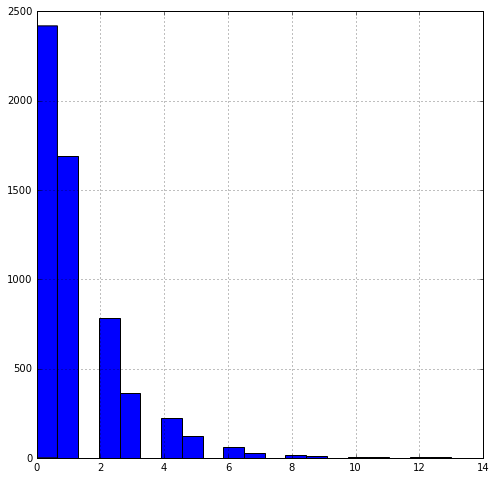

In [390]:
data_train['Number.of.Successful.Grant.1'].hist(bins=20)

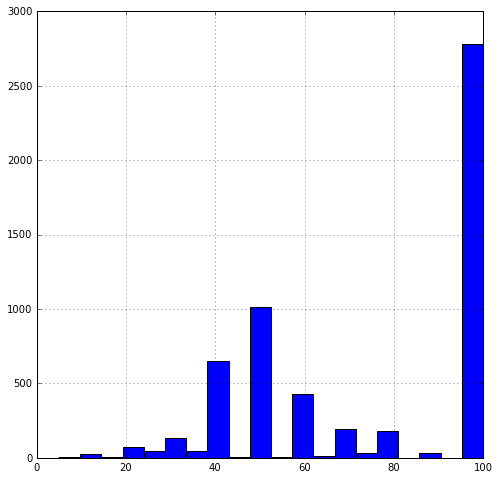

In [391]:
data_train['RFCD.Percentage.1'].hist(bins=20)

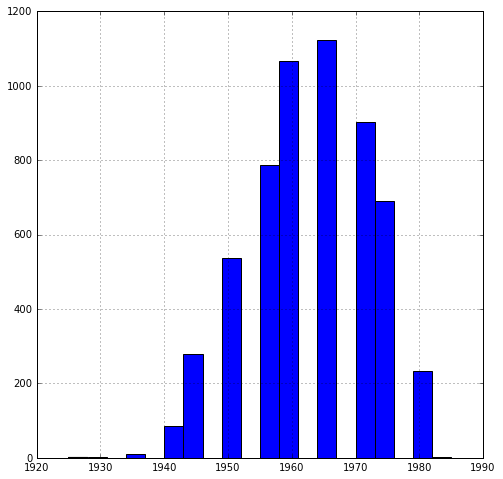

In [392]:
data_train['Year.of.Birth.1'].hist(bins=20)

Какую проблему вы наблюдаете на этих графиках? Как масштабирование поможет её исправить?

Признаки имеют сильно различающиеся области определения. Масштабирование поможет преобразовать каждый из признаков в одную область значений.

В наших данных есть пропуски. Ответьте на вопросы:
1. Сколько всего пропущенных элементов в таблице с обучающей выборкой?
2. Сколько объектов имеют хотя бы один пропуск?
3. Сколько признаков имеют хотя бы одно пропущенное значение?

Сколько всего пропущенных элементов в таблице с обучающей выборкой?

In [393]:
data_train.isnull().sum().sum()

26843

Сколько объектов имеют хотя бы один пропуск?

In [394]:
data_train.isnull().any(axis=1).sum()

5879

Сколько признаков имеют хотя бы одно пропущенное значение?

In [395]:
data_train.isnull().any(axis=0).sum()

38

Большинство признаков в нашем датасете являются категориальными. Типичным подходом к работе с ними является бинарное, или one-hot-кодирование (также есть подход со счётчиками, который мы уже применяли в прошлых работах). Для начала потренируемся делать бинарное кодирование на трех игрушечных объектах.

In [396]:
simple_data = pd.DataFrame({'City': ['Msk', 'SPb', 'Msk'], 'Weather': ['good', 'bad', 'worst']})
simple_data.head()

,City,Weather
0,Msk,good
1,SPb,bad
2,Msk,worst


In [397]:
# преобразуем каждый объект в dict
simple_data_dict = simple_data.T.to_dict().values()
print simple_data_dict

[{'City': 'Msk', 'Weather': 'good'}, {'City': 'SPb', 'Weather': 'bad'}, {'City': 'Msk', 'Weather': 'worst'}]


In [398]:
# делаем one-hot-кодирование
from sklearn.feature_extraction import DictVectorizer
transformer = DictVectorizer(sparse=False)

transformer.fit_transform(simple_data_dict)
# примените здесь DictVectorizer к simple_data_dict, получите бинарную матрицу и выведите её

array([[ 1.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.]])

In [399]:
transformer.feature_names_

['City=Msk', 'City=SPb', 'Weather=bad', 'Weather=good', 'Weather=worst']

Реализуйте функцию transform_data, которая принимает на вход DataFrame с признаками, объекты классов StandardScaler и DictVectorizer и булеву переменную is_test (True, если обрабатывает тестовую выборку и False, если обучающую). В функции должны выполняться следующие шаги:
1. Замена пропущенных значений на нули для вещественных признаков и на строки 'nan' для категориальных. Используйте для выполнения замены функцию fillna. Имена всех вещественных переменных перечислены в numeric_cols.
2. Масштабирование вещественных признаков с помощью StandardScaler (метод fit_transform, если is_test == False, и метод transform в противном случае).
3. One-hot-кодирование категориальных признаков с помощью DictVectorizer (метод fit_transform, если is_test == False, и метод transform в противном случае).

Метод должен возвращать tuple из трех элементов: преобразованной выборки, объекта StandardScaler и объекта DictVectorizer. Преобразованная выборка должна состоять из масштабированных вещественных признаков и закодированных категориальных (исходные признаки не должны в ней остаться).

In [1027]:
def transform_data(data, scaler, transformer, is_test):
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    categoriacal_cols = list(set(data_train.columns) - set(numeric_cols))

    data[numeric_cols] = data[numeric_cols].fillna(value=0)
    data[categoriacal_cols] = data[categoriacal_cols].fillna(value='nan').astype(str)

    if not is_test:
        data_numeric = scaler.fit_transform(data[numeric_cols].values)
        data_categorical = transformer.fit_transform(data[categoriacal_cols].T.to_dict().values())
    else:
        data_numeric = scaler.transform(data[numeric_cols].values)
        data_categorical = transformer.transform(data[categoriacal_cols].T.to_dict().values())
        
    return sps.hstack((data_numeric, data_categorical), format='csr'), scaler, transformer

Применяем функцию к данным:

In [1028]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transformer = DictVectorizer()
X, scaler, transformer = transform_data(data_train, scaler, transformer, False)
X_test, _, _ = transform_data(data_test, scaler, transformer, True)

Сколько признаков у вас получилось после преобразования?

In [651]:
print X.shape[1]

11734


#### Задание 3
Подберите лучшее значение параметра регуляризации C для логистической регрессии с L2-регуляризатором (sklearn.linear_model.LogisticRegression) с помощью кросс-валидации по 5 блокам. В качестве метрики качества используйте AUC-ROC. Сетка для перебора указана ниже. По итогам кросс-валидации укажите лучшее значение параметра регуляризации. Обучите классификатор с этим параметром на всей обучающей выборке и найдите качество (AUC-ROC) на тестовой выборке.

In [99]:
from sklearn.cross_validation import KFold
cv = KFold(X.shape[0], n_folds=5, shuffle=True, random_state=241)

In [123]:
# вам пригодятся функции cross_val_score или GridSearchCV; используйте в них объект cv в качестве генератора разбиений
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

C_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

grid_searcher = GridSearchCV(estimator=LogisticRegression(penalty='l2'), 
                             param_grid=dict(C=C_grid), 
                             scoring='roc_auc',
                             cv=cv, 
                             refit=True,
                             n_jobs=-1)

grid_searcher.fit(X, target_train)
grid_searcher.best_score_, grid_searcher.best_params_

(0.88238879035649076, {'C': 0.1})

Финальный AUC

In [124]:
roc_auc_score(target_test, grid_searcher.predict_proba(X_test)[:, 1])

0.88034905991937784

Попробуем теперь логистическую регрессию с L1-регуляризатором (penalty='l1'). Выведите число ненулевых коэффициентов (clf.coef\_) при каждом значении параметра регуляризации из сетки.

In [136]:
from sklearn.cross_validation import cross_val_score

for C in C_grid:
    clf = LogisticRegression(C=C, penalty='l1')
    auc_score = cross_val_score(clf, X, target_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    clf.fit(X, target_train)
    
    print 'C={0:>5} AUC={1:<15} NON_ZEROS={2:<20}'.format(C, np.mean(auc_score), np.count_nonzero(clf.coef_))

C=0.001 AUC=0.5             NON_ZEROS=0                   
C= 0.01 AUC=0.859972226879  NON_ZEROS=9                   
C=  0.1 AUC=0.877446477412  NON_ZEROS=58                  
C=  1.0 AUC=0.880450261007  NON_ZEROS=668                 
C= 10.0 AUC=0.865774103776  NON_ZEROS=2469                
C=100.0 AUC=0.864014329375  NON_ZEROS=2844                


Какое качество на тесте даёт логистическая регрессия с L1-регуляризатором с параметром C=0.01? Сколько для достижения такого качества ей нужно признаков?

__AUC равен 0.85997, всего ненулевыми остаются 9 признаков__

#### Задание 4
В этом задании мы внимательно рассмотрим различные аспекты качества классификатора. Для этого возьмите классификатор с L2-регуляризатором с лучшим значением параметра регуляризации (вы его нашли в предыдущем задании), обучите на полной обучающей выборке и найдите предсказания вероятностей на тесте. Далее будем работать только с этими прогнозами.

In [239]:
predictions = LogisticRegression(C=0.1, penalty='l2').fit(X, target_train).predict_proba(X_test)

Посчитайте AUC-ROC, AUC-PR (average_precision_score) и log-loss для прогнозов.

In [231]:
from sklearn.metrics import average_precision_score, roc_auc_score, log_loss

print "AUC-ROC =", roc_auc_score(target_test, predictions[:, 1])
print "AUC-PR =", average_precision_score(target_test, predictions[:, 1])
print "LOG-LOSS =", log_loss(target_test, predictions[:, 1])

AUC-ROC = 0.880349059919
AUC-PR = 0.838758043121
LOG-LOSS = 0.442737702403


Нарисуйте ROC- и PR-кривые. Не забудьте подписать оси.

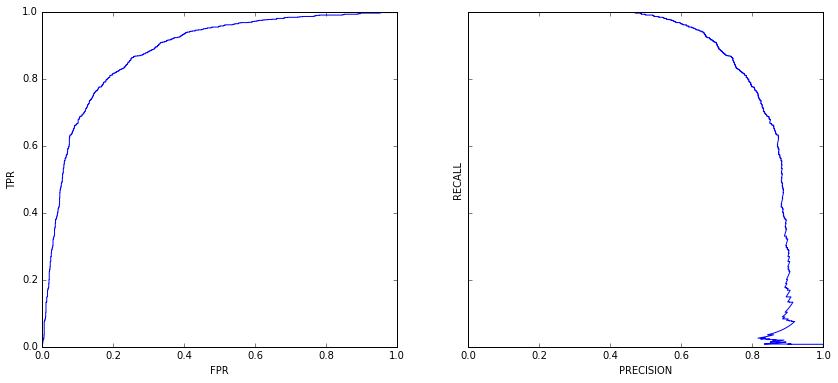

In [233]:
from sklearn.metrics import roc_curve, precision_recall_curve

fprs, tprs, thresholds = roc_curve(target_test, predictions[:, 1])
precisions, recalls, thresholds = precision_recall_curve(target_test, predictions[:, 1])

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 6), sharex=True, sharey=True)
axes[0].plot(fprs, tprs)
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')

axes[1].plot(precisions, recalls)
axes[1].set_ylabel('RECALL')
axes[1].set_xlabel('PRECISION')

Допустим, мы хотим построить классификатор, который будет находить не менее 90% успешных грантов. Соответственно, имеем нижнюю границу 90% на полноту. Какую максимальную точность при этом можно получить? При каком значении порога? Для получения ответа проанализируйте массивы, возвращаемые функцией metrics.precision_recall_curve.

In [246]:
max_precision = np.max(precisions[recalls >= 0.9])
max_precision_ind = np.argmax(precisions == max_precision)

print 'MAX_PRECISION =', max_precision
print 'THRESHOLD =', thresholds[max_precision_ind]

MAX_PRECISION = 0.701948051948
THRESHOLD = 0.314958503338


Возьмите классификатор с порогом из предыдущего пункта и подсчитайте для него F-меру. Почему она получилась маленькой, несмотря на высокую полноту?

In [177]:
pos = np.argmax(precisions[recalls >= 0.9])
precision = precisions[pos]
recall = recalls[pos]
2 * (precision * recall) / (precision + recall)

0.78876322510032837

(0, 1)

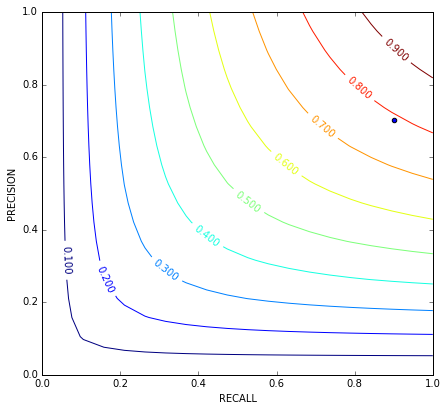

In [252]:
xx, yy = np.meshgrid(np.linspace(0, 1, 20), np.linspace(0, 1, 20))
zz = 2 * (xx * yy) / (xx + yy)

plt.figure(figsize=(7, 6.5))
contours = plt.contour(xx, yy, zz, 10)
plt.clabel(contours, inline=1, fontsize=10)

plt.xlabel('RECALL')
plt.ylabel('PRECISION')

plt.scatter(recall, precision)
plt.xlim([0, 1])
plt.ylim([0, 1])

__Низкое значение является причиной того, что f-мера есть компромис между полнотой и точностью. В нашем случае как раз плохая точность понижает f-меру.__

Допустим, что университету важно подавать как можно меньше заявок, которые окажутся неуспешными — они очень плохо влияют на репутацию. Установим нижнюю границу на точность 80%. Какую максимальную полноту при этом можно обеспечить? При каком пороге?

In [253]:
max_recall = np.max(recalls[precisions >= 0.8])
max_recall_ind = np.argmax(recalls == max_recall)

print 'MAX_RECALL =', max_recall
print 'THRESHOLD =', thresholds[max_recall_ind]

MAX_RECALL = 0.776019983347
THRESHOLD = 0.527838710938


#### Задание 5
В этом задании мы научимся оценивать способность классификатора предсказывать вероятности, а также разберемся с калибровкой.

Начнем с калибровочных кривых. Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [263]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
        
    plt.plot(bin_middle_points, bin_real_ratios)

Проверим её работу на логистической регрессии (поменяйте имена переменных, если это необходимо). Получилась ли почти диагональная калибровочная кривая?

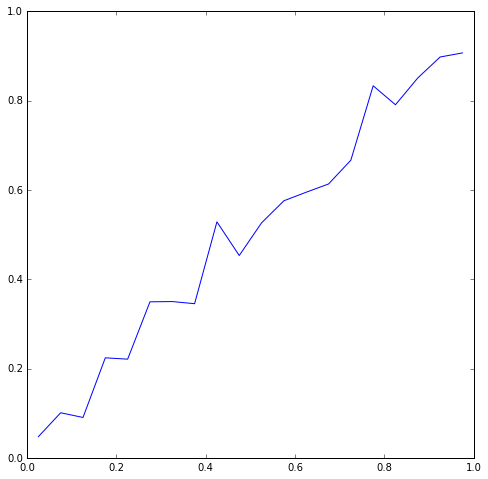

In [647]:
clf = LogisticRegression(C=1.0)
clf.fit(X, target_train)
preds = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(target_test, preds)

__Да, почти__

Заодно обратим внимание на то, как часто классификатор выдает те или иные вероятности.

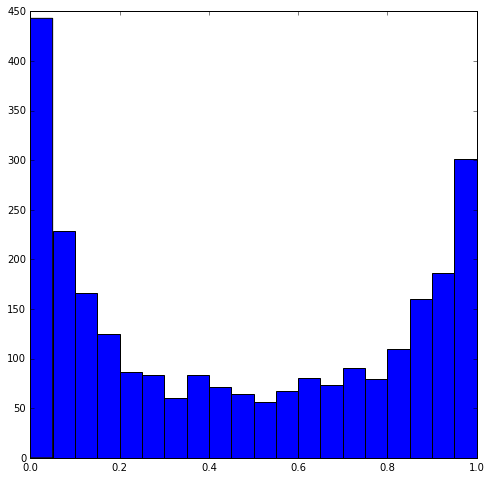

In [265]:
plt.hist(preds, bins=20)
plt.show()

Обучим теперь классификатор с кусочно-линейной функцией потерь (hinge loss, как в SVM).

In [268]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
clf.fit(X, target_train)
preds = clf.decision_function(X_test)
preds = 1.0 / (1.0 + np.exp(-preds))

Изучите распределение ответов классификатора. Чем оно отличается от распределения у логистической регрессии? Чем вы можете объяснить это?

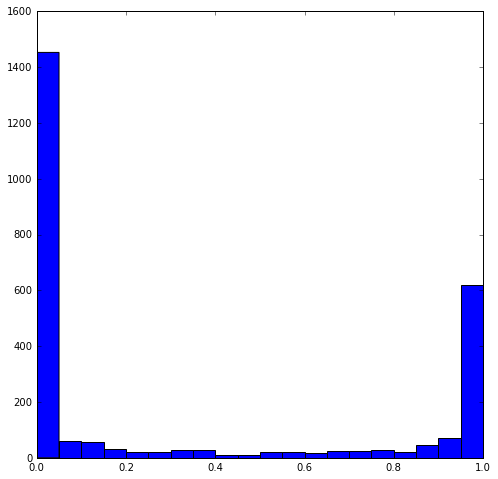

In [269]:
plt.hist(preds, bins=20)
plt.show()

Найдем минимум мат ожидания $\mathbb{E}_y\left[\, hinge\_loss(y, b(x)) \mid x \,\right]$ по всем возможным алгоритмам $b$.

Получим, что 
$$
b(x) = 
   \begin{cases} 
       \:\;1, & p(y = 1 \mid x) \ge \frac{1}{2} \\
      -1, & p(y = 1 \mid x) < \frac{1}{2}\\
   \end{cases} 
$$

То есть, при минимизации hinge_loss мы будем получать алгоритм не с корректными вероятностями на выходе, а алгоритм, который будет стараться относить к положительному классу все объекты, для которых $p \ge \frac{1}{2}$. Данный результат мы видим на гистограмме.

Нарисуем калибровочную кривую. Видите ли вы какие-либо проблемы в ней?

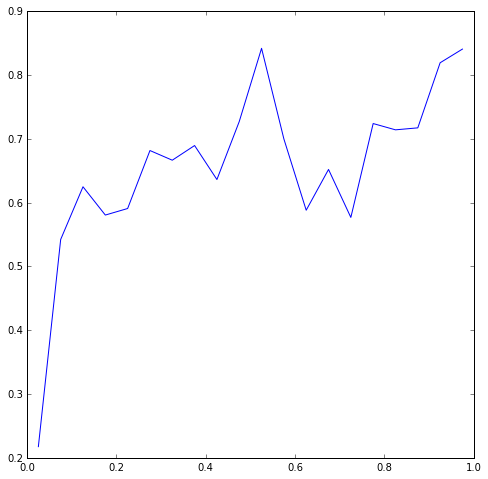

In [271]:
plot_calibration_curve(target_test, preds)

__Она совсем далека от диагональной формы__

Попробуем откалибровать вероятности. Грубо говоря, это процедура, которая для каждого отрезка $[a_i, b_i]$ строит преобразование, которое корректирует вероятности в нем, приводя тем самым калибровочную кривую к диагональной форме.

Воспользуйтесь классом sklearn.calibration.CalibratedClassifierCV для калибровки вероятностей на обучении, и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [293]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_classifier = CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge'))
calibrated_classifier.fit(X, target_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
            cv=3, method='sigmoid')

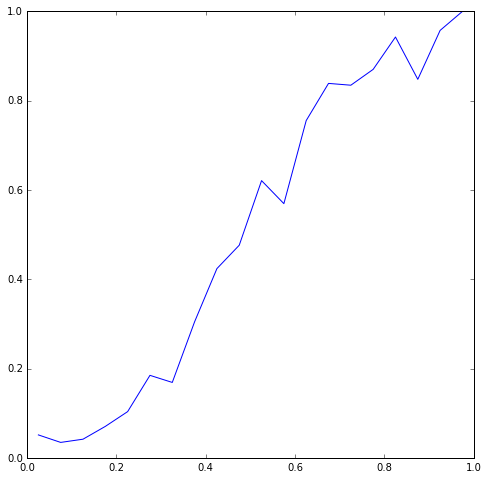

In [294]:
pred = calibrated_classifier.predict_proba(X_test)
plot_calibration_curve(target_test, pred[:, 1])

__Да, стала немного лучше__

#### Задание 6
Здесь вы можете вставить вашу любимую картинку про Австралию.

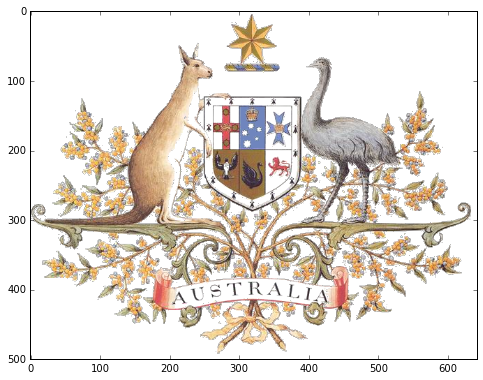

In [300]:
plt.imshow(plt.imread('http://2.bp.blogspot.com/-4peTLNrHixs/VM14ReUWR8I/AAAAAAAACoA/iiB0akZByDE/s1600/Australia_gerb.png'))

## Часть 2. Градиентный спуск своими руками
**(опциональная часть, за правильное выполнение к оценке добавляется 3 балла)**

В этой части вам предстоит самостоятельно реализовать градиентный спуск для логистической функции потерь — то есть, по сути, собственными руками обучить логистическую регрессию. Будем использовать данные из предыдущей части.

Добавьте к обучающей и тестовой выборкам единичный признак. Переведите значения целевого вектора в множество $\{-1, +1\}$.

In [655]:
X = sps.hstack((np.ones((X.shape[0], 1)), X), format='csr').toarray()
X_test = sps.hstack((np.ones((X_test.shape[0], 1)), X_test), format='csr').toarray()

In [1040]:
target_train = 2 * target_train - 1
target_test = 2 * target_test - 1

Для начала реализуйте функции, которые вычисляют функционал, его градиент, а также прогнозы модели.

In [874]:
def sigmoid(x):
    pos_sigmoid = lambda z: 1 / (1 + np.exp(-z))
    neg_sigmoid = lambda z: np.exp(z) / (1 + np.exp(z))
    return np.piecewise(x.astype(float), [x > 0, x <= 0], [pos_sigmoid, neg_sigmoid])

In [875]:
# возвращает вектор предсказанных вероятностей для выборки X
def make_pred(X, w):
    return sigmoid(np.dot(X, w))

In [876]:
# возвращает значение логистического функционала для выборки (X, y) и вектора весов w
def get_func(w, X, y):
    pos_func = lambda x:   - np.log(1 + np.exp(-x))
    neg_func = lambda x: x - np.log(1 + np.exp(x))
    
    x = y * np.dot(X, w)
    
    return - np.piecewise(x.astype(float), [x > 0, x <= 0], [pos_func, neg_func]).sum()

In [931]:
# возвращает градиент логистического функционала для выборки (X, y) и вектора весов w
def get_grad(w, X, y):
    return np.dot(X.T,  y * (sigmoid(y * np.dot(X, w)) - 1))

Теперь реализуйте градиентный спуск (не стохастический). Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В градиентном спуске должно выполняться не более max_iter итераций.

In [982]:
def grad_descent(X, y, step_size, max_iter):
    w = np.zeros(X.shape[1])
    func_values = np.zeros(max_iter)
    
    for i in range(max_iter):
        func_values[i] = get_func(w, X, y)
        w -= step_size * get_grad(w, X, y)
        
    return w, func_values

Запустите градиентный спуск для значений размера шага из набора [0.001, 1, 10]. Нарисуйте кривые зависимости значения функционала от номера итерации. Проанализируйте их. Вычислите AUC-ROC на тестовой выборке для лучшего из обученных вариантов.

In [983]:
max_iter = 50
losses = []
ws = []

for learning_rate in [0.001, 1, 10]:
    w, loss = grad_descent(X, target_train.values, learning_rate, max_iter)
    losses.append(loss)
    ws.append(w)

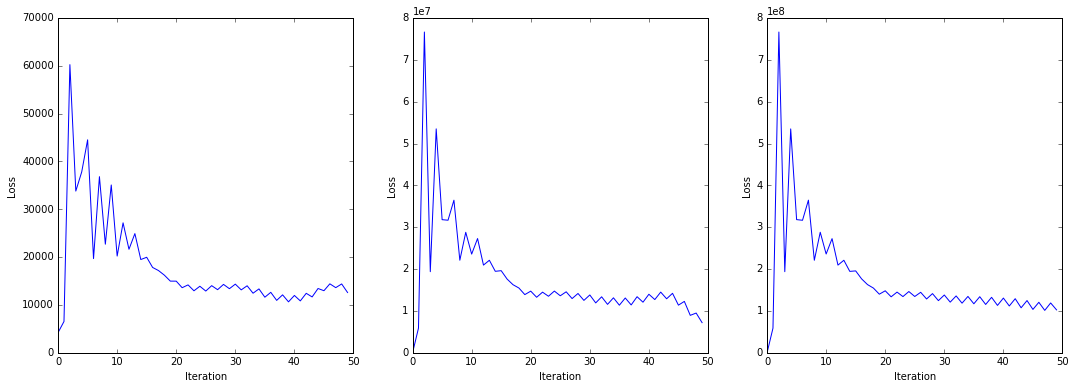

In [901]:
iteration_nums = np.arange(max_iter)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for i in range(3):
    axes[i].plot(iteration_nums, losses[i])
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel('Loss')

__При слишком больших learning_rate градиентный спуск делает слишком большие скачки, тем самым проскакивая точку минимума__

In [902]:
roc_auc_score(target_test, make_pred(X_test, ws[0]))

0.86133044228959343

Теперь реализуйте стохастический градиентный спуск. Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В стохастическом градиентном спуске должно выполняться не более max_iter итераций.

In [984]:
def sgd(X, y, step_size, max_iter):
    w = np.zeros(X.shape[1])
    func_values = np.zeros(max_iter)
    
    for i in range(max_iter):
        func_values[i] = get_func(w, X, y)
        shuffle_inds = np.random.permutation(X.shape[0])
        
#         for j in shuffle_inds: 
        j = np.random.randint(0, X.shape[0] - 1)
        w -= step_size * y[j] * X[j] * (sigmoid(y[j] * np.dot(X[j], w)) - 1)
            
    return w, func_values

Подберите размер шага, при котором SGD будет сходиться. Нарисуйте график сходимости. Вычислите AUC-ROC на тестовой выборке.

In [1017]:
max_iter = 150
w, loss = sgd(X, target_train.values, 0.001, max_iter)

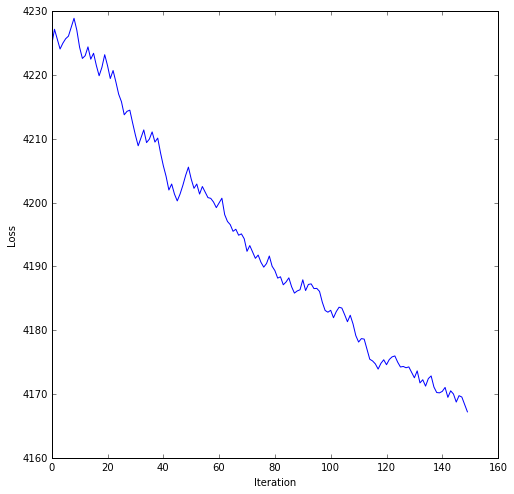

In [1018]:
iteration_nums = np.arange(max_iter)
plt.plot(iteration_nums, loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [1019]:
roc_auc_score(target_test, make_pred(X_test, w))

0.73735767879930081

А теперь самое сложное: заново сформируйте выборку с помощью transform_data, но теперь не масштабируйте вещественные признаки. Запустите на этой выборке градиентный спуск. Что вы наблюдаете? Удается ли достичь такого же качества, как и при использовании масштабирования?

In [1039]:
from sklearn.preprocessing import FunctionTransformer
transformer = DictVectorizer()
scaler = FunctionTransformer()
X, scaler, transformer = transform_data(data_train, scaler, transformer, False)
X_test, _, _ = transform_data(data_test, scaler, transformer, True)

X = sps.hstack((np.ones((X.shape[0], 1)), X), format='csr').toarray()
X_test = sps.hstack((np.ones((X_test.shape[0], 1)), X_test), format='csr').toarray()

In [1041]:
w, loss = grad_descent(X, target_train.values, 0.01, 50)
roc_auc_score(target_test, make_pred(X_test, w))

0.49918888414517654

__Качество значительно хуже, чем при масштабировании признаков__

Здесь вы можете поделиться своими мыслями по поводу этой части.

__Очень полезная часть. Всегда думал, что эти алгоритмы просты в реализации. При ближайшем столкновении нашлись подводные камни, решение этих проблем оказалось поучительным.__

## Часть 3. Линейная регрессия на простом примере

В этой части мы очень кратко разберемся с линейной регрессией и измерением качества ее прогнозов. Будем использовать датасет diabetes.

In [1044]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
data = datasets.load_diabetes()
X, X_test, y, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

Обучите линейную регрессию с L2-регуляризатором, подобрав лучшее значение параметра регуляризации на тестовой выборке. Используйте MSE в качестве тестовой выборки. При каком значении этого параметра достигается наилучшее качество?

In [1047]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

alpha_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
scores = []

for alpha in alpha_grid:
    ridge_regression = Ridge(alpha=alpha)
    ridge_regression.fit(X, y)
    scores.append(mean_squared_error(y_test, ridge_regression.predict(X_test)))

In [1053]:
alpha_grid[np.argmin(scores)], np.min(scores)

(0.1, 3096.0301510144977)

Вычислите для лучшей из моделей RMSE и коэффициент детерминации (r2_score) на тестовой выборке. Что вы можете сказать о значении коэффицинта детерминации? Насколько данная модель близка к оптимальной?

In [1054]:
from sklearn.metrics import r2_score

ridge_regression = Ridge(alpha=0.1)
ridge_regression.fit(X, y)
r2_score(y_test, ridge_regression.predict(X_test))

0.41702418482173675

Данная модель может объяснить менее половины всей дисперсии. Скорее всего линейная модель делает слишком сильные предположения в данном случае.